In [46]:
# kerchunk==0.2.7
# xarray==2025.1.2
# ujson==5.10.0
# earthaccess==0.14.0
# matplotlib==3.10.0
# virtualizarr==1.2.0

In [12]:
import os
import ujson

import fsspec
import earthaccess

import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
from virtualizarr import open_virtual_dataset

import matplotlib.pyplot as plt

In [4]:
# Get Earthdata creds
earthaccess.login()

# Get AWS creds
fs_data = earthaccess.get_s3_filesystem(daac="PODAAC")

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [35]:
# Locate file information / metadata:
granule_info = earthaccess.search_data(
    short_name="OSTIA-UKMO-L4-GLOB-REP-v2.0",
    count=100
    )

In [36]:
s3_endpoints = [g.data_links(access="direct")[0] for g in granule_info]

In [37]:
fobjs = earthaccess.open(granule_info)

QUEUEING TASKS | :   0%|          | 0/100 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/100 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/100 [00:00<?, ?it/s]

## Create reference file with kerchunk

In [38]:
%%time
# Individual references:
single_refs_kerchunk = [
    SingleHdf5ToZarr(fobj, ep, inline_threshold=0).translate() 
    for fobj, ep in zip(fobjs, s3_endpoints)
    ]

CPU times: user 4.95 s, sys: 1.3 s, total: 6.25 s
Wall time: 44 s


In [39]:
%%time
# Combined reference:
kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs_data.storage_options, 'concat_dims':["time"]}
combined_ref_kerchunk = MultiZarrToZarr(single_refs_kerchunk, **kwargs_mzz).translate()

# Save reference to JSON:
with open("ref_combined_kerchunk.json", 'wb') as outf:
    outf.write(ujson.dumps(combined_ref_kerchunk).encode())

CPU times: user 642 ms, sys: 47.9 ms, total: 690 ms
Wall time: 18.7 s


## Create reference file with virtualizarr

In [40]:
%%time

# Create single ref files:
singe_refs_virtualizarr = [
    open_virtual_dataset(ep, indexes={}, reader_options={"storage_options": fs_data.storage_options})
    for ep in s3_endpoints
    ]

# Create combined ref file and save to json:
combined_ref_virtualizarr = xr.combine_nested(singe_refs_virtualizarr, concat_dim='time', coords='minimal', compat='override', combine_attrs='drop_conflicts')
combined_ref_virtualizarr.virtualize.to_kerchunk("ref_combined_virtualizarr.json", format='json')

CPU times: user 9.07 s, sys: 1.82 s, total: 10.9 s
Wall time: 59.1 s


## Compare opening data with the two ref files

In [41]:
def opendf_withref(ref, fs_data):
    """
    Wrapper function to open data with xarray, using a ref file. "ref" is a reference file or object. 
    "fs_data" is a filesystem with credentials to access the data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    m = fsspec.filesystem('reference', **storage_opts).get_mapper('')
    return xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
        )

In [42]:
%%time
data_kerchunk = opendf_withref("ref_combined_kerchunk.json", fs_data)
print(data_kerchunk)

<xarray.Dataset> Size: 73GB
Dimensions:           (time: 100, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 800B 1982-01-01T12:00:00 ... 1982...
Data variables:
    analysed_sst      (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm

In [43]:
%%time
data_virtualizarr = opendf_withref("ref_combined_virtualizarr.json", fs_data)
print(data_virtualizarr)

<xarray.Dataset> Size: 73GB
Dimensions:           (time: 100, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 800B 1982-01-01T12:00:00 ... 1982...
Data variables:
    analysed_sst      (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm

CPU times: user 1.67 s, sys: 74.8 ms, total: 1.74 s
Wall time: 1.78 s


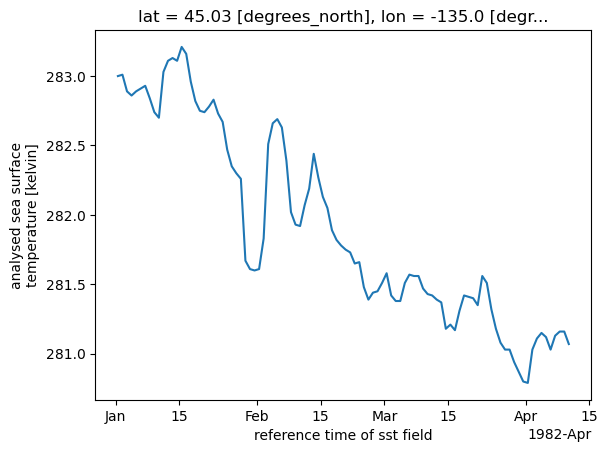

In [44]:
%%time
data_kerchunk["analysed_sst"].sel(lat=45, lon=-135, method='nearest').plot()

CPU times: user 1.66 s, sys: 64.4 ms, total: 1.72 s
Wall time: 1.44 s


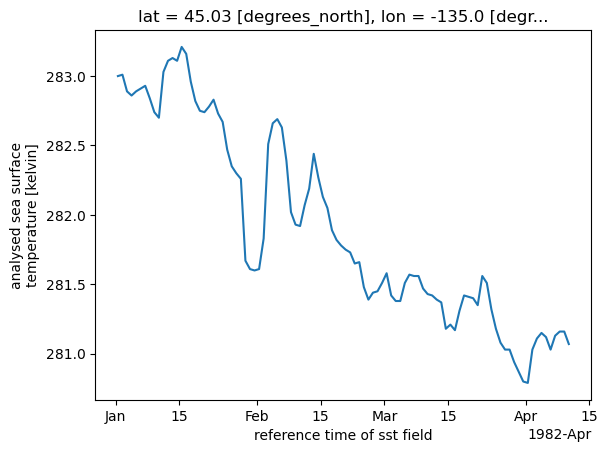

In [45]:
%%time
data_virtualizarr["analysed_sst"].sel(lat=45, lon=-135, method='nearest').plot()